# Tutorial: Uncovering Independent Processes in Molecular Dynamics Data using MoSAIC and PyMOL Visualization

This tutorial explains how to extract clusters for T4 Lysozyme using MoSAIC. 
> **Correlation-Based Feature Selection to Identify Functional Dynamcis
> in Proteins**  
> G. Diez, D. Nagel, and G. Stock,
> *J. Chem. Theory Comput.* **2022** 18 (8), 5079-5088,
> [10.1021/acs.jctc.2c00337](https://pubs.acs.org/doi/10.1021/acs.jctc.2c00337)



The assumption is that the necessary internal coordinates, 
such as contact distances, have already been calculated. 

A file with every 10000th frame of the 402 contact distances from 
> Identification and Validation of Reaction Coordinates Describing Protein 
> Functional Motion: Hierarchical Dynamics of T4 Lysozyme
> M. Ernst, S. Wolf and G. Stock (*J. Chem. Theory Comput.* **2017** 13, 5076)

is provided.
Additionally, an index-file is provided that specifies the columns of the 
coordinate file. 
So, for example, the first line of the index-file contains 
>1  5

which means that the first column in the coordinate file corresponds to the 
minimal distance between the first and fifth residue.

The data is loaded using the **mosaic** package, and the correlation matrix is 
calculated using the **Similarity** class and the **correlation** metric. 
Once the correlation matrix has been computed, the next step is to cluster the 
data using the Leiden algorithm with the constant Potts model. 


## Computing the Correlation

In [14]:
import mosaic
import numpy as np


# Load the data
internal_coords = np.loadtxt('./t4l_exampletraj_mindists.dat')
internal_coords_names = np.loadtxt(
    './t4l_exampletraj_mindists_names.idx',
).astype(int)

# Calculate the correlation matrix
sim = mosaic.Similarity(metric='correlation')
sim.fit(internal_coords)
correlation_matrix = sim.matrix_

## Clustering 

In this example, a resolution parameter of gamma=0.5 is used. 
Depending on the size of the matrix and the value of the resolution parameter,
the clustering might need some time (higher resolution parameters require more
time).
Therefore, a cutoff can be used for large matrices to mask all correlation 
entries below a certain threshold.

In [15]:
# Cluster the correlation matrix
clustering = mosaic.Clustering(
    mode='CPM',
    weighted=True,
    resolution_parameter=0.5,
)
clustering.fit(correlation_matrix);

Once the clustering process is completed, the next step is to visualize the 
matrix.

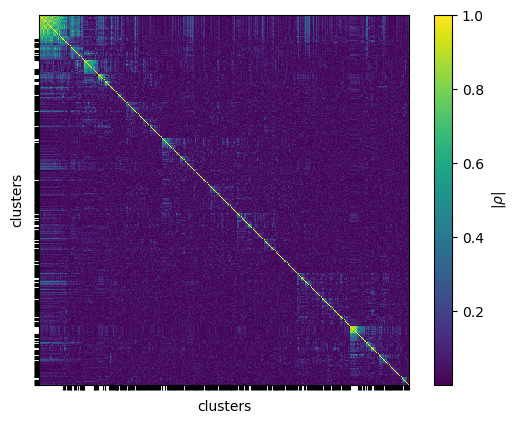

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.pcolormesh(clustering.matrix_)
ax.invert_yaxis()  # origin to the upper left
ax.set_aspect('equal')  # 1:1 ratio
ax.set_xticks(clustering.ticks_)
ax.set_yticks(clustering.ticks_)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('clusters')
ax.set_ylabel('clusters')
ax.grid(False)
plt.colorbar(im, label=r'$|\rho|$')
plt.show()

Sometimes it can be useful to sort the clusters by size before visualizing. 
This allows us to see which clusters are largest and play a key role in the 
process we want to study.
To sort the clusters by size, we can first calculate the size of each cluster 
and sort them in descending order. 
We can then reorder the rows and columns of the matrix based on this sorted 
order. This way, the largest clusters will be in the upper left corner of the 
heatmap, while the smallest clusters will be in the lower right corner.
Such a  reordering makes it easier to identify and interpret the larger, 
more meaningful clusters in the data.

In [17]:
idxs = np.argsort(
    [len(cluster) for cluster in clustering.clusters_],
)[::-1]
clusters_sorted = clustering.clusters_[idxs]
clusters_sorted_flattened = np.concatenate(clustering.clusters_[idxs])

# sort the matrix accordingly
matrix_sorted = correlation_matrix[
    np.ix_(clusters_sorted_flattened, clusters_sorted_flattened)
]
ticks = np.cumsum([len(cluster) for cluster in clustering.clusters_[idxs]])
ticks = [0, *ticks[:-1]]  # ticks start with 0 

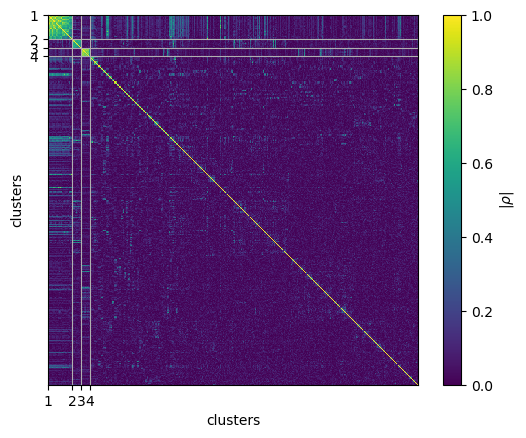

In [18]:
# Perform the same plot again, but with sorted clusters
fig, ax = plt.subplots()
im = ax.pcolormesh(
    matrix_sorted,
    snap=True,
    vmin=0,
    vmax=1,
)
ax.invert_yaxis()  # origin to the upper left
ax.set_aspect('equal')  # 1:1 ratio
ax.set_xticks(ticks[:4])  # we focus only on the first three clusters
ax.set_yticks(ticks[:4])
ax.set_xticklabels(np.arange(4)+1)
ax.set_yticklabels(np.arange(4)+1)
ax.set_xlabel('clusters')
ax.set_ylabel('clusters')
ax.grid(True)
plt.colorbar(im, label=r'$|\rho|$')
plt.show()

Great! By applying clustering analysis to our MD data, we have identified three
distinct clusters (1, 2, and 3) that describe independent processes. 
We have also observed that the majority of coordinates do not belong to a large
cluster because they feature very few correlations with other coordinates
(all these coordinates are simply combined here as cluster 4). 
This suggests that the coordinates in cluster 4 can be discarded as they do not
contribute significantly to the dynamics of the system.

Now we need to extract the coordinates of the residues belonging to a 
particular cluster, e.g., cluster 1, and visualize them as a 3D structure. 
To accomplish this, we will use the open source version of PyMOL, 
a powerful visualization tool that allows us to render and manipulate 
molecular structures (https://pymol.org/2/#opensource).

To create a PyMOL script to achieve this, we first generate a string that 
contains all the information about the residues in this cluster. 
We can use the cluster assignments obtained earlier and the topology file of 
the simulated system to retrieve the atom names and coordinates of the residues
in the cluster. Once we have this information, 
we can format it into a PyMOL script that selects and colors the residues in 
cluster 1.

After generating the PyMOL script, we can run it using PyMOL's command-line 
interface to generate a 3D structure of the cluster. Finally, we will save the 
structure in a .png format.

The PyMOL settings provided here are just an example and can be adjusted to 
suit the user's preferences.

In [19]:
import pymol
from IPython.display import Image
pymol.cmd.feedback('disable', 'all', 'everything')  # suppress pymol output

In [20]:
# create structure plots for the first three MoSAIC clusters
for cluster in range(3):
    pymol_cmd = """
        reinitialize; load t4l_structure.pdb;
        set cartoon_discrete_colors, on;
        util.cbss("all","silver","silver","white",_self=cmd);
        bg_color white;
        set ray_trace_mode,  1;
        set ray_texture, 5;
        set ray_trace_fog, 0;
        set antialias, 2;
        set stick_radius, .2;
        set sphere_scale, .3;
        set sphere_scale, .2, elem H;
        set stick_quality, 50;
        set sphere_quality, 4;
        set ambient, 0.1;
        set shininess, 10;
        set specular, 1;
        set reflect, .5;
        set dash_gap, 0;
        set dash_color, red;
        set dash_length, .05;
        set dash_round_ends, 0;
        set dash_radius, .2;
        set depth_cue, 0;
        set label_size, 0;
        set_view (\
             0.155398622,    0.833652616,    0.529968441,\
             0.252840698,    0.485050529,   -0.837133050,\
            -0.954944849,    0.264088452,   -0.135405213,\
             0.000078902,   -0.000241295, -156.730316162,\
            19.574779510,   34.417434692,   46.308376312,\
           128.238204956,  185.230773926,  -20.000000000 );
    """
    for num, coord in enumerate(clusters_sorted[cluster]):
        c1, c2 = internal_coords_names[coord];
        pymol_cmd += f'distance dist{num}, {c1}/CA, {c2}/CA ;\n'
        pymol_cmd += f'select CA{num}, {c1}/CA or {c2}/CA ;\n'
        pymol_cmd += f'show spheres, CA{num} ;\n'
    pymol_cmd += f'ray 800; 800; png t4l_cluster{cluster + 1}.png;'
    pymol.cmd.do(pymol_cmd);

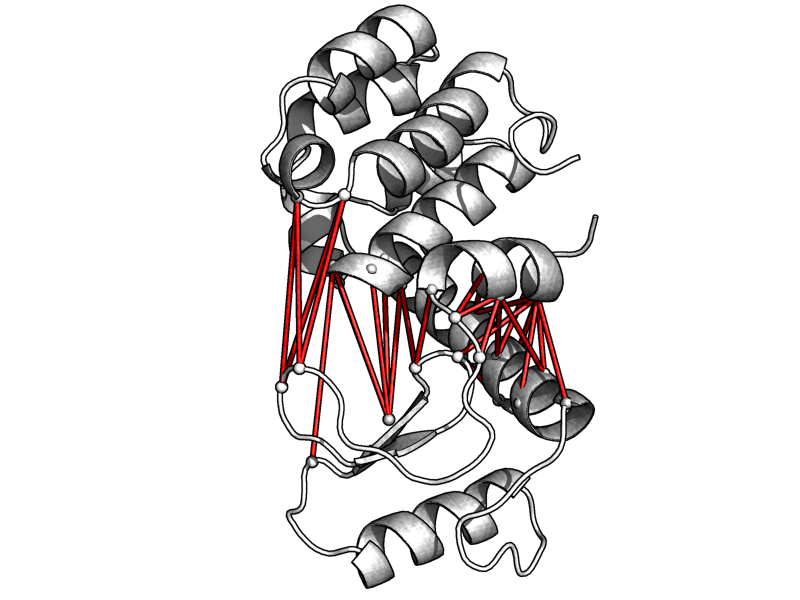

In [21]:
Image('./t4l_cluster1.png')

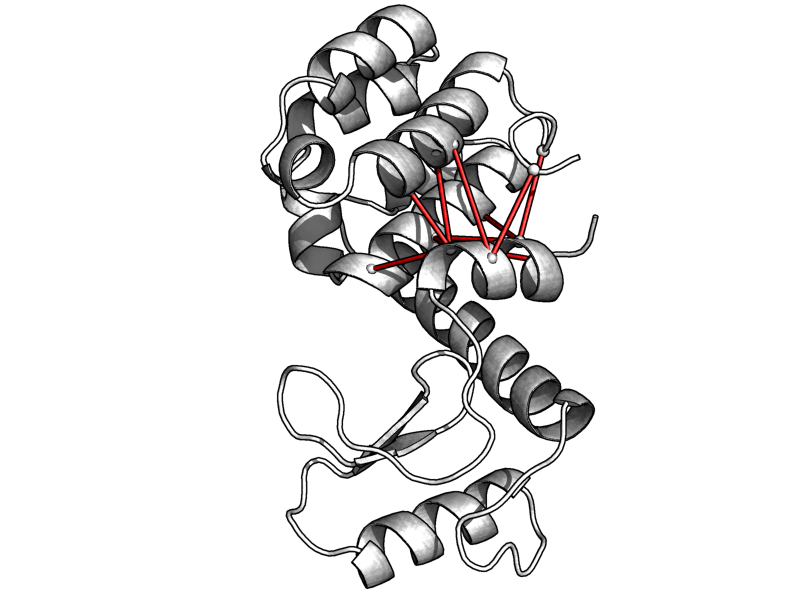

In [22]:
Image('./t4l_cluster2.png')

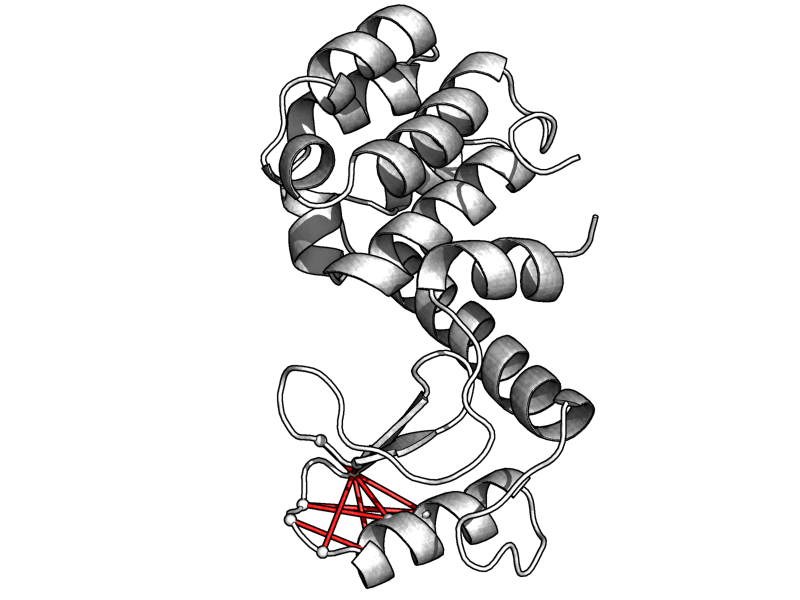

In [23]:
Image('./t4l_cluster3.png')

## Conclusion
In conclusion, our MoSAIC analysis of the MD data allowed us to identify three 
important clusters of coordinates, each describing independent processes. 
By visualizing these clusters using PyMOL, we were able to extract their
coordinates and gain insights into their structural characteristics. 

Additionally, we found that the majority of coordinates were not significantly
correlated with any other coordinate, indicating that they can be discarded 
from further analysis. 
This approach can be useful for identifying key coordinates and processes in 
large MD datasets and can aid in understanding complex biological processes.